In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,),)])

trainset = datasets.FashionMNIST("", download=True, train=True, transform=transform)
testset = datasets.FashionMNIST("", download=True, train=False, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
net = Net()
print(net)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
optimiser = optim.Adam(net.parameters(), lr=0.0001)

EPOCHS = 5

for epoch in range(EPOCHS):
    for data in trainLoader:
        X, y = data
        net.zero_grad()
        output = net(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimiser.step()
    print(loss)

tensor(0.1637, grad_fn=<NllLossBackward0>)
tensor(0.2347, grad_fn=<NllLossBackward0>)
tensor(0.0406, grad_fn=<NllLossBackward0>)
tensor(0.1881, grad_fn=<NllLossBackward0>)
tensor(1.0659, grad_fn=<NllLossBackward0>)


In [5]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        X, y = data
        output = net(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))
print(correct)
print(total)

Accuracy:  0.864
8642
10000


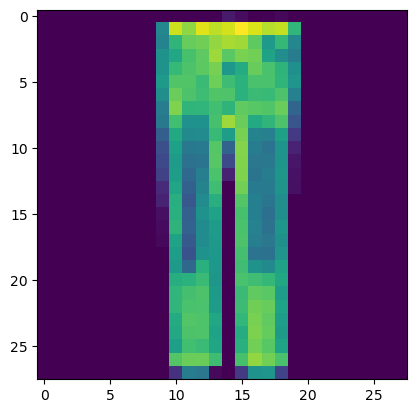

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X[4].view(28,28))
plt.show()

In [7]:
labelIndex = 4
print(class_labels[torch.argmax(net(X[labelIndex])[0])])
print(class_labels[y[labelIndex]])

Trouser
Trouser


In [8]:
net.eval()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
batch_size = 1
x = torch.randn(batch_size, 1, 28, 28, requires_grad=True)
#x = torch.Tensor(X)
netOut = net(x)

torch.onnx.export(net,
                  x,
                  "fashionFlatten1.onnx",
                  export_params=True,
                  input_names=['input'],
                  do_constant_folding=True,
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [10]:
import onnx

onnx_model = onnx.load("fashionFlatten1.onnx")
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input[FLOAT, batch_sizex1x28x28]
) initializers (
  %fc1.weight[FLOAT, 128x784]
  %fc1.bias[FLOAT, 128]
  %fc2.weight[FLOAT, 10x128]
  %fc2.bias[FLOAT, 10]
) {
  %/flatten/Flatten_output_0 = Flatten[axis = 1](%input)
  %/fc1/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%/flatten/Flatten_output_0, %fc1.weight, %fc1.bias)
  %/Relu_output_0 = Relu(%/fc1/Gemm_output_0)
  %/fc2/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%/Relu_output_0, %fc2.weight, %fc2.bias)
  %output = LogSoftmax[axis = 1](%/fc2/Gemm_output_0)
  return %output
}


In [11]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("fashionFlatten1.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
#ort_outputs = ort_session.get_outputs()[0].name
ort_outs = ort_session.run(None, ort_inputs)

import numpy as np

np.testing.assert_allclose(to_numpy(netOut), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Success")
print(ort_session)

Success


In [12]:
ort_outs[0]

array([[-2.3133373, -2.9493208, -3.1774812, -4.840892 , -2.0173652,
        -1.3745353, -1.7997645, -3.0083365, -3.0071058, -1.9038426]],
      dtype=float32)

In [13]:
netOut

tensor([[-2.3133, -2.9493, -3.1775, -4.8409, -2.0174, -1.3745, -1.7998, -3.0083,
         -3.0071, -1.9038]], grad_fn=<LogSoftmaxBackward0>)

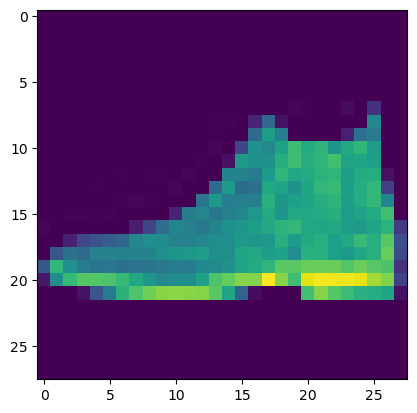

Ankle boot


In [14]:
X, y = testset[0]
plt.imshow(X.view(28,28))
plt.show()
print(class_labels[y])

In [15]:
print(class_labels[torch.argmax(net(X))])

Ankle boot


In [16]:
to_numpy(net(X))

array([[-12.572902  , -14.273725  , -11.802283  , -11.380926  ,
         -9.771669  ,  -2.2001493 , -11.364032  ,  -1.7038848 ,
         -5.203463  ,  -0.35432202]], dtype=float32)

In [17]:
torch.argmax(torch.from_numpy(to_numpy(net(X))))

tensor(9)

In [18]:
inX = X.unsqueeze(0) #X.view(-1,784)
print({ort_session.get_inputs()[0].name: to_numpy(inX)})

{'input': array([[[[-1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        , -1.        ,
          -1.        , -1.        , -1.        , -1.      

In [19]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inX)}
#ort_outputs = ort_session.get_outputs()[0].name
out0 = ort_session.run(None, ort_inputs)

In [20]:
print(out0[0])
print(ort_session)

[[-12.572901   -14.273723   -11.802281   -11.380927    -9.7716675
   -2.2001488  -11.364031    -1.7038838   -5.2034616   -0.35432234]]


In [21]:
class_labels[torch.argmax(torch.from_numpy(out0[0]))]

'Ankle boot'